In [1]:
from pathlib import Path

import matplotlib.cm
import matplotlib.patches
import pandas as pd
import spectral_cube.utils
from astropy.visualization import quantity_support
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from scipy.optimize import curve_fit
from spectral_cube import SpectralCube

from regions import CircleSkyRegion
import numpy as np
import chemical_names
from astroquery.simbad import Simbad
import warnings
import traceback
import astropy.units as u

quantity_support()
%matplotlib inline

In [2]:
def gauss(x, H, A, x0, sigma):
    """Gaussian function with a background"""
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


def gauss_fit(x, y):
    """Fit a gaussian into data"""
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt


def sigma_from_data(data: np.ndarray) -> float:
    """Find rms of the data by fitting a gaussian into the histogram
    (assuming most of the pixels are noise)"""
    values, edges = np.histogram(data, bins=100, density=True)
    means = 0.5 * (edges[1:] + edges[:-1])
    params = gauss_fit(means, values)
    plt.step(means, values, where="mid")
    print(params)
    plt.plot(means, gauss(means, *params))
    return params[3]


def finalize_plot(axes, cube, window, dist_pc, ctr_data=None, ellcolor="black", **kwargs):
    pxsize = np.sqrt(np.abs(np.linalg.det(cube.wcs.celestial.pixel_scale_matrix)))
    try:
        axes.coords[0].set_major_formatter('hh:mm:ss')
        axes.coords[1].set_major_formatter('dd:mm:ss')
        axes.coords[0].set_ticks(spacing=5 * u.arcsec)  #, format="hh:mm:ss")
        axes.coords[1].set_ticks(spacing=5 * u.arcsec)  #, format="dd:mm:ss")
        axes.coords[0].set_ticklabel(exclude_overlapping=True)
        axes.coords[1].set_ticklabel(exclude_overlapping=True)
    except AttributeError:
        pass
    axes.scatter(
        0, 0,
        color='white', marker='x', zorder=100
    )
    if ctr_data is not None:
        noise = sigma_from_data(ctr_data)
        try:
            noise_value = noise.value
        except AttributeError:
            noise_value = noise
        ctr_3sigma = axes.contour(
            ctr_data,
            levels=[3 * noise_value],
            colors='black',
            linewidths=0.5,
        )
    else:
        ctr_3sigma = None
    try:
        ell = matplotlib.patches.Ellipse(
            (-0.8 * window, -0.8 * window),
            cube.beam.major.to_value(u.arcsec) * dist_pc,
            cube.beam.minor.to_value(u.arcsec) * dist_pc,
            cube.beam.pa.value + 90,
            hatch='///',
            color=ellcolor
        )
        axes.add_patch(ell)
    except spectral_cube.utils.NoBeamError as e:
        pass
    return {"ctr_3sigma": ctr_3sigma}

In [3]:
paper_figs_folder = Path("/Users/franceschi/Desktop/figs/")
cubes_root = Path(r"observations_new/")
disks = ["DN Tau", "DM Tau", "CY Tau", "CI Tau", "DL Tau", "IQ Tau",]
# weighting = "briggs"
molecules = ["CO", "13CO", "C18O"]
cmaps = [matplotlib.colormaps[color] for color in ["Blues", "Oranges", "Greens", "Reds",
                                                     "Purples", "YlOrBr", "RdPu", "Greys", "YlGn", "GnBu"]]
colors = ["C0", "C1", "C2", "C3", "C4"]

vrange = {
    "CI Tau": (2, 10),
    "DN Tau": (3, 9),
    "DM Tau": (3, 9),
    "CY Tau": (4.5, 10),
    "IQ Tau": (3, 9),
    "UZ Tau": (3, 9),
    "DL Tau": (3, 9),
}
cloud = {
    # "CI Tau": (4.1, 6.6, ["CO", "13CO", "C18O"]),
    # "CI Tau": {"CO": (4.1, 6.4), "13CO": (5., 5.5), "C18O": (5., 5.5)},
}

In [4]:
rows_list = []

for disk in disks:
    for molecule in molecules:
        try:
            fitsfiles = (cubes_root / disk.replace(" ", "")).glob(f"{molecule}_cut.fits")
            path = (cubes_root / disk.replace(" ", "")).glob(f"{molecule}_cut.fits").__next__()
            # print(disk, molecule, path, path.exists())
            rows_list.append({"disk": disk, "molecule": molecule, "path": path})
        except StopIteration:
            path = None
            # print(disk, molecule, path, False)

df = pd.DataFrame(rows_list)
df

,disk,molecule,path
0,DN Tau,CO,observations_new/DNTau/CO_cut.fits
1,DN Tau,13CO,observations_new/DNTau/13CO_cut.fits
2,DN Tau,C18O,observations_new/DNTau/C18O_cut.fits
3,DM Tau,CO,observations_new/DMTau/CO_cut.fits
4,DM Tau,13CO,observations_new/DMTau/13CO_cut.fits
5,DM Tau,C18O,observations_new/DMTau/C18O_cut.fits
6,CY Tau,CO,observations_new/CYTau/CO_cut.fits
7,CY Tau,13CO,observations_new/CYTau/13CO_cut.fits
8,CY Tau,C18O,observations_new/CYTau/C18O_cut.fits
9,CI Tau,CO,observations_new/CITau/CO_cut.fits


In [5]:
simquery = Simbad()
simquery.add_votable_fields('distance', 'velocity')
simbad_data = simquery.query_objects(disks)
simbad_data

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,RVZ_TYPE,RVZ_RADVEL,RVZ_ERROR,RVZ_QUAL,RVZ_WAVELENGTH,RVZ_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,,,,km / s,km / s,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float64,str1,str4,float64,float64,str8,str19,str1,float64,float32,str1,str1,object,int32
V* DN Tau,04 35 27.3776,+24 14 58.910,14,14,0.020,0.012,90,A,O,2020yCat.1350....0G,128.6010,,pc,-0.3655,0.3655,paral,2020yCat.1350....0G,v,17.408,0.005,A,N,2020AJ....160..120J,1
V* DM Tau,04 33 48.7336,+18 10 09.973,14,14,0.018,0.010,90,A,O,2020yCat.1350....0G,144.0490,,pc,-0.4503,0.4503,paral,2020yCat.1350....0G,v,18.607,0.011,A,O,2012ApJ...745..119N,2
V* CY Tau,04 17 33.7284,+28 20 46.812,14,14,0.019,0.011,90,A,O,2020yCat.1350....0G,126.3300,,pc,-0.3256,0.3256,paral,2020yCat.1350....0G,v,16.725,0.005,A,N,2020AJ....160..120J,3
V* CI Tau,04 33 52.0143,+22 50 30.094,14,14,0.019,0.012,90,A,O,2020yCat.1350....0G,160.3180,,pc,-0.5269,0.5269,paral,2020yCat.1350....0G,v,17.731,0.008,A,N,2020AJ....160..120J,4
V* DL Tau,04 33 39.0767,+25 20 38.101,14,14,0.017,0.011,90,A,O,2020yCat.1350....0G,159.9360,,pc,-0.4962,0.4962,paral,2020yCat.1350....0G,v,17.324,0.011,A,N,2020AJ....160..120J,5
V* IQ Tau,04 29 51.5569,+26 06 44.859,14,14,0.032,0.022,90,A,O,2020yCat.1350....0G,131.5110,,pc,-0.6209,0.6209,paral,2020yCat.1350....0G,v,15.602,0.008,A,N,2020AJ....160..120J,6


### Peak of an image in K

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for _disk in set(df['disk']):
        # for _molecule in df[(df['disk'] == _disk)]['molecule']:
        for _molecule in ['CO']:
            file = df.query(f"disk == '{_disk}' and molecule == '{_molecule}'").path.values[0]
            
            cube = SpectralCube.read(file, format="fits")
            dist_pc = simbad_data[disks.index(f'{_disk}')]["Distance_distance"]
            window = 1000
            radius = (
                    window * u.au
                    / (dist_pc * u.pc)
            ).to(
                u.arcsec, equivalencies=u.dimensionless_angles()
            )
            center = cube.wcs.celestial.pixel_to_world(cube.shape[1] / 2, cube.shape[2] / 2)
            region = CircleSkyRegion(center, radius)
            cube.allow_huge_operations = True
            image_sigma = cube.to(u.K).std()
            cube = cube.subcube_from_regions([region])
            spectral_subcube = cube.to(u.K).with_spectral_unit(u.km / u.s, velocity_convention="radio").spectral_slab(*(vrange[f'{_disk}'] * (u.km / u.s)))
            
            image_peak = spectral_subcube.max()
            print(f'{_disk} {_molecule} peak: {image_peak:.1f}')

CI Tau CO peak: 20.0 K
CY Tau CO peak: 11.2 K
DN Tau CO peak: 15.5 K
DM Tau CO peak: 17.0 K
IQ Tau CO peak: 11.2 K
DL Tau CO peak: 11.8 K


In [6]:
file = df.query(f"disk == 'IQ Tau' and molecule == 'CO'").path.values[0]

cube = SpectralCube.read(file, format="fits")
dist_pc = simbad_data[disks.index('IQ Tau')]["Distance_distance"]
window = 1000
radius = (
        window * u.au
        / (dist_pc * u.pc)
).to(
    u.arcsec, equivalencies=u.dimensionless_angles()
)
center = cube.wcs.celestial.pixel_to_world(cube.shape[1] / 2, cube.shape[2] / 2)
region = CircleSkyRegion(center, radius)
cube.allow_huge_operations = True
image_sigma = cube.to(u.K).std()
cube = cube.subcube_from_regions([region])
spectral_subcube = cube.to(u.K).with_spectral_unit(u.km / u.s, velocity_convention="radio").spectral_slab(*(vrange['IQ Tau'] * (u.km / u.s)))

# spectral_subcube.write(Path("~/Desktop/test.fits"))
image_peak = spectral_subcube.max()
image_peak

<Quantity 11.23967239 K>

### Plots and saves the max and the mom0 image for all the disks and molecules

observations_new/DNTau/CO_cut.fits
observations_new/DNTau/13CO_cut.fits
observations_new/DNTau/C18O_cut.fits
observations_new/DMTau/CO_cut.fits
observations_new/DMTau/13CO_cut.fits
observations_new/DMTau/C18O_cut.fits
observations_new/CYTau/CO_cut.fits
observations_new/CYTau/13CO_cut.fits
observations_new/CYTau/C18O_cut.fits
observations_new/CITau/CO_cut.fits
observations_new/CITau/13CO_cut.fits
observations_new/CITau/C18O_cut.fits
observations_new/DLTau/CO_cut.fits
observations_new/DLTau/13CO_cut.fits
observations_new/DLTau/C18O_cut.fits
observations_new/IQTau/CO_cut.fits
observations_new/IQTau/13CO_cut.fits
observations_new/IQTau/C18O_cut.fits


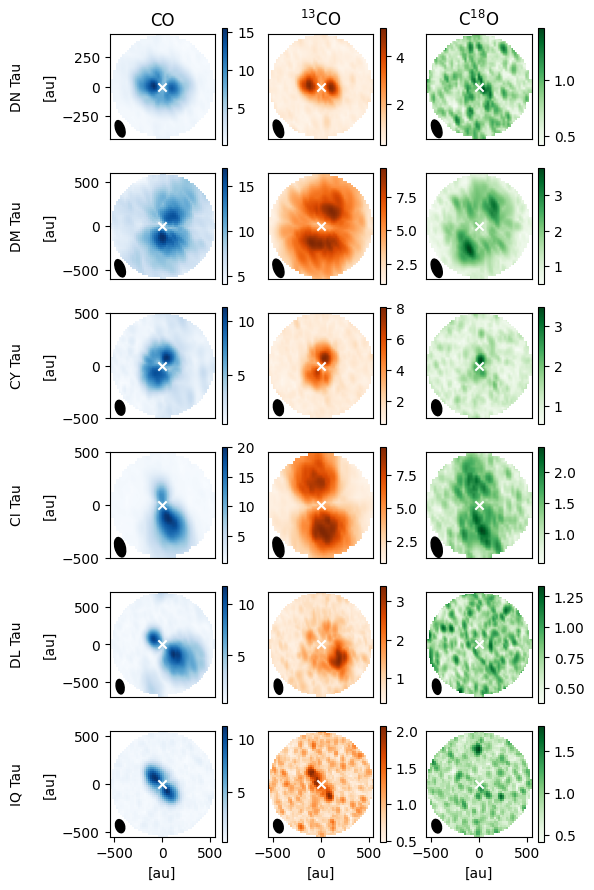

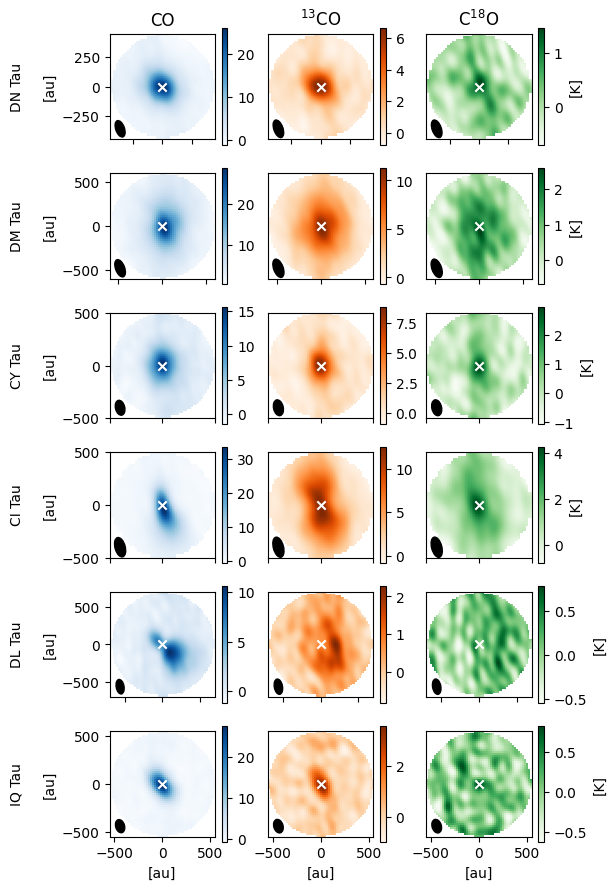

In [7]:
fig_max = plt.figure(figsize=(16, 16))
fig_mom0 = plt.figure(figsize=(16, 16))

window_list = [450, 600, 500, 500, 700, 550, 400]
warnings.filterwarnings("ignore")
for i, disk in enumerate(disks):
    window = window_list[i]
    shared_axes = []
    for j, molecule in enumerate(molecules):
        try:
            file = df.query(f"disk == '{disk}' and molecule == '{molecule}'").path.values[0]
            print(file)
            cube = SpectralCube.read(file, format="fits")

            center = cube.wcs.celestial.pixel_to_world(cube.shape[1] / 2, cube.shape[2] / 2)
            dist_pc = simbad_data[disks.index(disk)]["Distance_distance"]
            radius = (
                    window * u.au
                    / (dist_pc * u.pc)
            ).to(
                u.arcsec, equivalencies=u.dimensionless_angles()
            )
            region = CircleSkyRegion(center, radius)
            cube.allow_huge_operations = True
            image_sigma = cube.to(u.K).std()
            cube = cube.subcube_from_regions([region])
            spectral_subcube = (
                cube.to(u.K)
                .with_spectral_unit(u.km / u.s, velocity_convention="radio")
                .spectral_slab(*(vrange[disk] * (u.km / u.s)))
            )
            image_peak = spectral_subcube.max(axis=0)

            # shared_axes.append(ax)
            ax = fig_max.add_subplot(
                9, 8,
                1 + i * 8 + j,
                # projection=cube.wcs.celestial,
            )
            if i == 0:
                ax.set_title(chemical_names.from_data_or_string(molecule))
                ax.set_xlabel(" ")
                ax.xaxis.set_visible(False)
            if i == len(disks) - 1:
                ax.set_xlabel("[au]")
            else:
                ax.set_xlabel(" ")
                ax.xaxis.set_visible(False)

            if j == 0:
                label = disk
                ax.set_ylabel(f"{label}\n\n[au]")
            else:
                # ax.coords[1].set_ticks_visible(False)
                ax.yaxis.set_visible(False)
                # ax.set_ylabel(" ")

            im = ax.imshow(
                image_peak.value,
                cmap=cmaps[j],
                extent=[-window, window, -window, window],
                origin="lower"
            )
            channels_n = len(spectral_subcube.spectral_axis)
            cbar = fig_max.colorbar(im, ax=ax)
            finalize_plot(ax, cube, window, dist_pc)

            ax = fig_mom0.add_subplot(
                9, 8,
                1 + i * 8 + j,
                # projection=cube.wcs.celestial,
            )
            shared_axes.append(ax)
            if i == 0:
                ax.set_title(chemical_names.from_data_or_string(molecule))
                ax.set_xlabel(" ")
            if i == len(disks) - 1:
                ax.set_xlabel("[au]")
            else:
                ax.set_xlabel(" ")
                ax.set_xticklabels(" ")
            if j == 0:
                label = disk
                ax.set_ylabel(f"{label}\n\n[au]")
            else:
                # ax.coords[1].set_ticks_visible(False)
                ax.yaxis.set_visible(False)
                ax.set_ylabel(" ")
                # ax.set_yticklabels(" ")
            image_mom0 = (
                cube
                .to(u.K)
                .with_spectral_unit(u.km / u.s, velocity_convention="radio")
                .spectral_slab(*(vrange[disk] * (u.km / u.s)))
                .moment0()
            )
            im = ax.imshow(
                image_mom0.value,
                cmap=cmaps[j],
                extent=[-window, window, -window, window],
                origin="lower"
            )
            channel_width = np.abs(spectral_subcube.spectral_axis[1] - spectral_subcube.spectral_axis[0])
            cbar = fig_mom0.colorbar(im, ax=ax)
            if j == len(molecules) - 1:
                cbar.set_label("[K]")
            finalize_plot(ax, cube, window, dist_pc)
        except (IndexError, OSError) as e:
            print(f"{disk} {molecule}: error")
            print(traceback.format_exc())
            print(e)
            pass
    shared_axes[0].get_shared_x_axes().join(*shared_axes)
    shared_axes[0].get_shared_y_axes().join(*shared_axes)
del cube
fig_max.savefig(f"disks_peak.pdf", bbox_inches="tight")
fig_mom0.savefig(f"disks_mom0.pdf", bbox_inches="tight")

In [13]:
# disk = "DM Tau"
# molecule = "CO"
# file = df.query(f"disk == '{disk}' and molecule == '{molecule}'").path.values[0]
# display(file)
# cube = SpectralCube.read(file)
# display(cube)
#
# window = 1500
# center = cube.wcs.celestial.pixel_to_world(cube.shape[1] / 2, cube.shape[2] / 2)
# dist_pc = simbad_data[disks.index(disk)]["Distance_distance"]
# radius = (
#         window * u.au
#         / (dist_pc * u.pc)
# ).to(
#     u.arcsec, equivalencies=u.dimensionless_angles()
# )
# region = CircleSkyRegion(center, radius)
# cube.allow_huge_operations = True
# image_sigma = cube.to(u.K).std()
# cube: SpectralCube = (
#     cube.subcube_from_regions([region])
#     .spectral_slab(vrange[disk][0] * u.km / u.s, vrange[disk][1] * u.km / u.s)
#     .to(u.K)
#     .with_spectral_unit(u.km / u.s, velocity_convention="radio")
# )
# display(cube)
# cube.plot_channel_maps(5, 5, np.linspace(0, 60, 25, dtype=int), cmap="Blues", norm=Normalize(0, 0.9 * cube.max().value),
#                        textcolor='k')
# plt.show()
# downsampled_obs: SpectralCube = cube.downsample_axis(4, axis=0).with_spectral_unit(u.km / u.s)
# fig = plt.figure(figsize=(15, 15))
#
# edges = np.array((0.1, 0.9)) * downsampled_obs.max().value
# downsampled_obs.plot_channel_maps(4, 4, range(16), cmap="Blues", norm=Normalize(*edges),
#                               textcolor='k', decimals=1, textyloc=0.8, fig=fig)
# plt.show()

Qui sto provando a rifare il plot ma con i modelli

PosixPath('/Users/franceschi/mysims/diskchef_fitting_greg/Reference/TEST_DMTau_200_-1.4_31_21_0.55/CO_cut.fits')

PosixPath('/Users/franceschi/mysims/diskchef_fitting_greg/Reference/TEST_DMTau_200_-1.4_31_21_0.55/13CO_cut.fits')

PosixPath('/Users/franceschi/mysims/diskchef_fitting_greg/Reference/TEST_DMTau_200_-1.4_31_21_0.55/C18O_cut.fits')

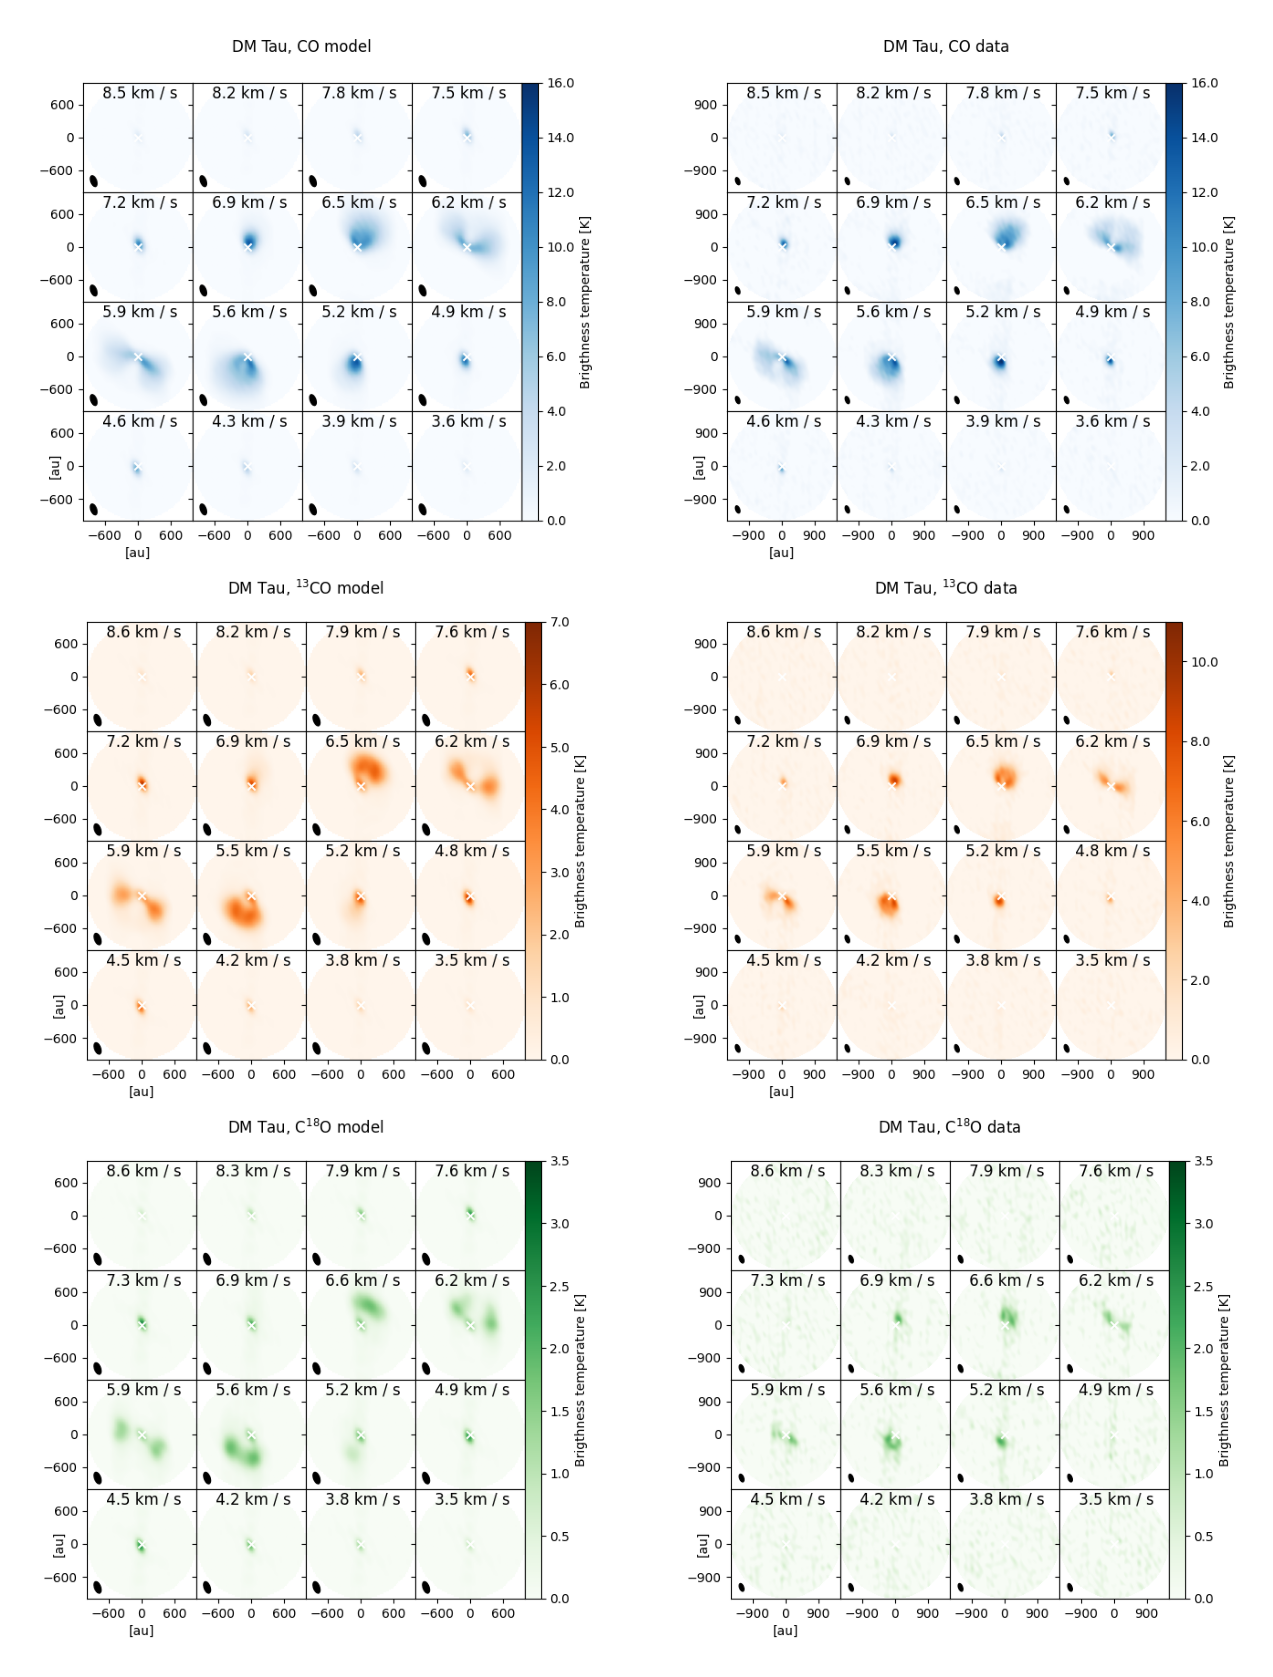

In [53]:
disk = ["DM Tau"]
model_path = Path('/Users/franceschi/mysims/diskchef_fitting_greg/Reference/TEST_DMTau_200_-1.4_31_21_0.55')
data_or_model = "model"
molecule = ["CO", "13CO", "C18O"]
root_output = Path(f"/Users/franceschi/Desktop/figs")
upper_limit = [16, 7, 3.5]
size = 1000
for window, disk in zip([size], disk):
    for i_molecule, _molecule in enumerate(molecule):
        try:
            file = None
            if data_or_model == "data":
                file = df.query(f"disk == '{disk}' and molecule == '{_molecule}'").path.values[0]
            elif data_or_model == "model":
                file = model_path / f'{_molecule}_cut.fits'
            display(file)
            cube = SpectralCube.read(file)

            center = cube.wcs.celestial.pixel_to_world(cube.shape[1] / 2, cube.shape[2] / 2)
            dist_pc = simbad_data[disks.index(disk)]["Distance_distance"]
            radius = (
                    window * u.au
                    / (dist_pc * u.pc)
            ).to(
                u.arcsec, equivalencies=u.dimensionless_angles()
            )
            region = CircleSkyRegion(center, radius)
            cube.allow_huge_operations = True
            image_sigma = cube.to(u.K).std()
            mid_channel = cube.closest_spectral_channel((vrange[disk][0] + vrange[disk][1]) * 0.5 * u.km / u.s)
            cube = cube[mid_channel - 32: mid_channel + 32]
            cube: SpectralCube = (
                cube.subcube_from_regions([region])
                .to(u.K)
                .with_spectral_unit(u.km / u.s, velocity_convention="radio")
            )

            downsampled: SpectralCube = cube.downsample_axis(4, axis=0).with_spectral_unit(u.km / u.s)
            ny = nx = 4
            # norm = Normalize(0, round(0.9 * downsampled.max().value, 1))
            # norm = Normalize(0, 14)
            norm = Normalize(0, upper_limit[i_molecule])
            cmap = cmaps[molecules.index(_molecule)]
            aspect_ratio = downsampled.shape[2] / float(downsampled.shape[1])
            fig_smallest_dim_inches = 6
            gridratio = ny / float(nx) * aspect_ratio
            if gridratio > 1:
                ysize = fig_smallest_dim_inches * gridratio
                xsize = fig_smallest_dim_inches * gridratio
            else:
                xsize = fig_smallest_dim_inches
                ysize = fig_smallest_dim_inches

            fig: Figure = plt.figure(figsize=(xsize, ysize))
            gs = GridSpec(nrows=ny, ncols=nx, hspace=0.0, wspace=0.0, figure=fig)
            ax = None
            window_half = round(window * 0.6, ndigits=-2)
            for i in range(ny):
                for j in range(nx):
                    ax = fig.add_subplot(
                        gs[i, j],
                        sharex=ax, sharey=ax
                    )
                    dist_pc = simbad_data[disks.index(disk)]["Distance_distance"]
                    im = ax.imshow(
                        downsampled[i * nx + j].value,
                        cmap=cmap,
                        norm=norm,
                        origin="lower",
                        extent=[-window, window, -window, window],
                    )
                    finalize_plot(ax, downsampled, window, dist_pc)
                    ax.text(
                        0.5,
                        0.9,
                        f"{downsampled.spectral_axis[i * nx + j]: .1f}",
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        fontsize=12
                    )
                    if disk in cloud.keys():
                        velocity = downsampled.spectral_axis[i * nx + j].to_value(u.km / u.s)
                        # print(disk, "has cloud, ", velocity)
                        if cloud[disk][0] < velocity < cloud[disk][1] and _molecule in cloud[disk][2]:
                            # print(velocity, "has cloud")
                            ax.scatter(0.5, 0.5, marker='x', color='red', alpha=0.2, transform=ax.transAxes, s=2000)
                    if i != ny - 1:
                        plt.setp(ax.get_xticklabels(), visible=False)
                    else:
                        ax.set_xticks([-window_half, 0, window_half])
                    if j != 0:
                        plt.setp(ax.get_yticklabels(), visible=False)
                    else:
                        ax.set_yticks([-window_half, 0, window_half])
                    if i == ny - 1 and j == 0:
                        ax.set_xlabel("[au]")
                        ax.set_ylabel("[au]", labelpad=-18)
            else:
                cax = fig.add_axes([0.90, 0.1, 0.03, 0.8])
                cb = fig.colorbar(im, cax=cax, format="%.1f")
                cb.set_label(f"Brigthness temperature [{downsampled.unit.to_string()}]")
            gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1)
            fig.suptitle(f"{disk}, {chemical_names.from_string(_molecule)} {data_or_model}")
            plt.savefig(f"{molecule}_{disk}_channel_maps.pdf")
        except (IndexError, OSError) as e:
            print(f"{disk} {molecule}: error")
            print(traceback.format_exc())
            print(e)
            pass
        path_output = root_output / f"{disk}_{_molecule}_{data_or_model}.png"
        plt.savefig(path_output, bbox_inches="tight")
        plt.close()
path_output = Path(f"/Users/franceschi/Desktop/figs/{model_path.name}.png")
obs_paths = []
model_paths = []
for _molecule in molecule:
    obs_paths.append(paper_figs_folder / f"{disk}_{_molecule}_model.png")
    model_paths.append(paper_figs_folder / f"{disk}_{_molecule}_data.png")

f, axes = plt.subplots(len(obs_paths), 2, figsize=(12, 7), dpi=300)
for i, (_obs_path, _model_path) in enumerate(zip(obs_paths, model_paths)):
    if len(obs_paths) == 1:
        axes_row = axes
    else:
        axes_row = [axes[i, 0], axes[i, 1] ]

    _im_obs, _im_model = mpimg.imread(_obs_path), mpimg.imread(_model_path)

    axes_row[0].imshow(_im_obs)
    axes_row[1].imshow(_im_model)

    for _ax in axes_row:
        _ax.set_axis_off()
    plt.subplots_adjust(wspace=-0.7, hspace=0)

    plt.savefig(path_output, bbox_inches="tight")

d: DN Tau


PosixPath('/Users/franceschi/mysims/diskchef_fitting_greg/Reference/test_DNTau_60_-1.7_16_4_0.55/CO_cut_residuals.fits')

PosixPath('/Users/franceschi/mysims/diskchef_fitting_greg/Reference/test_DNTau_60_-1.7_16_4_0.55/13CO_cut_residuals.fits')

PosixPath('/Users/franceschi/mysims/diskchef_fitting_greg/Reference/test_DNTau_60_-1.7_16_4_0.55/C18O_cut_residuals.fits')

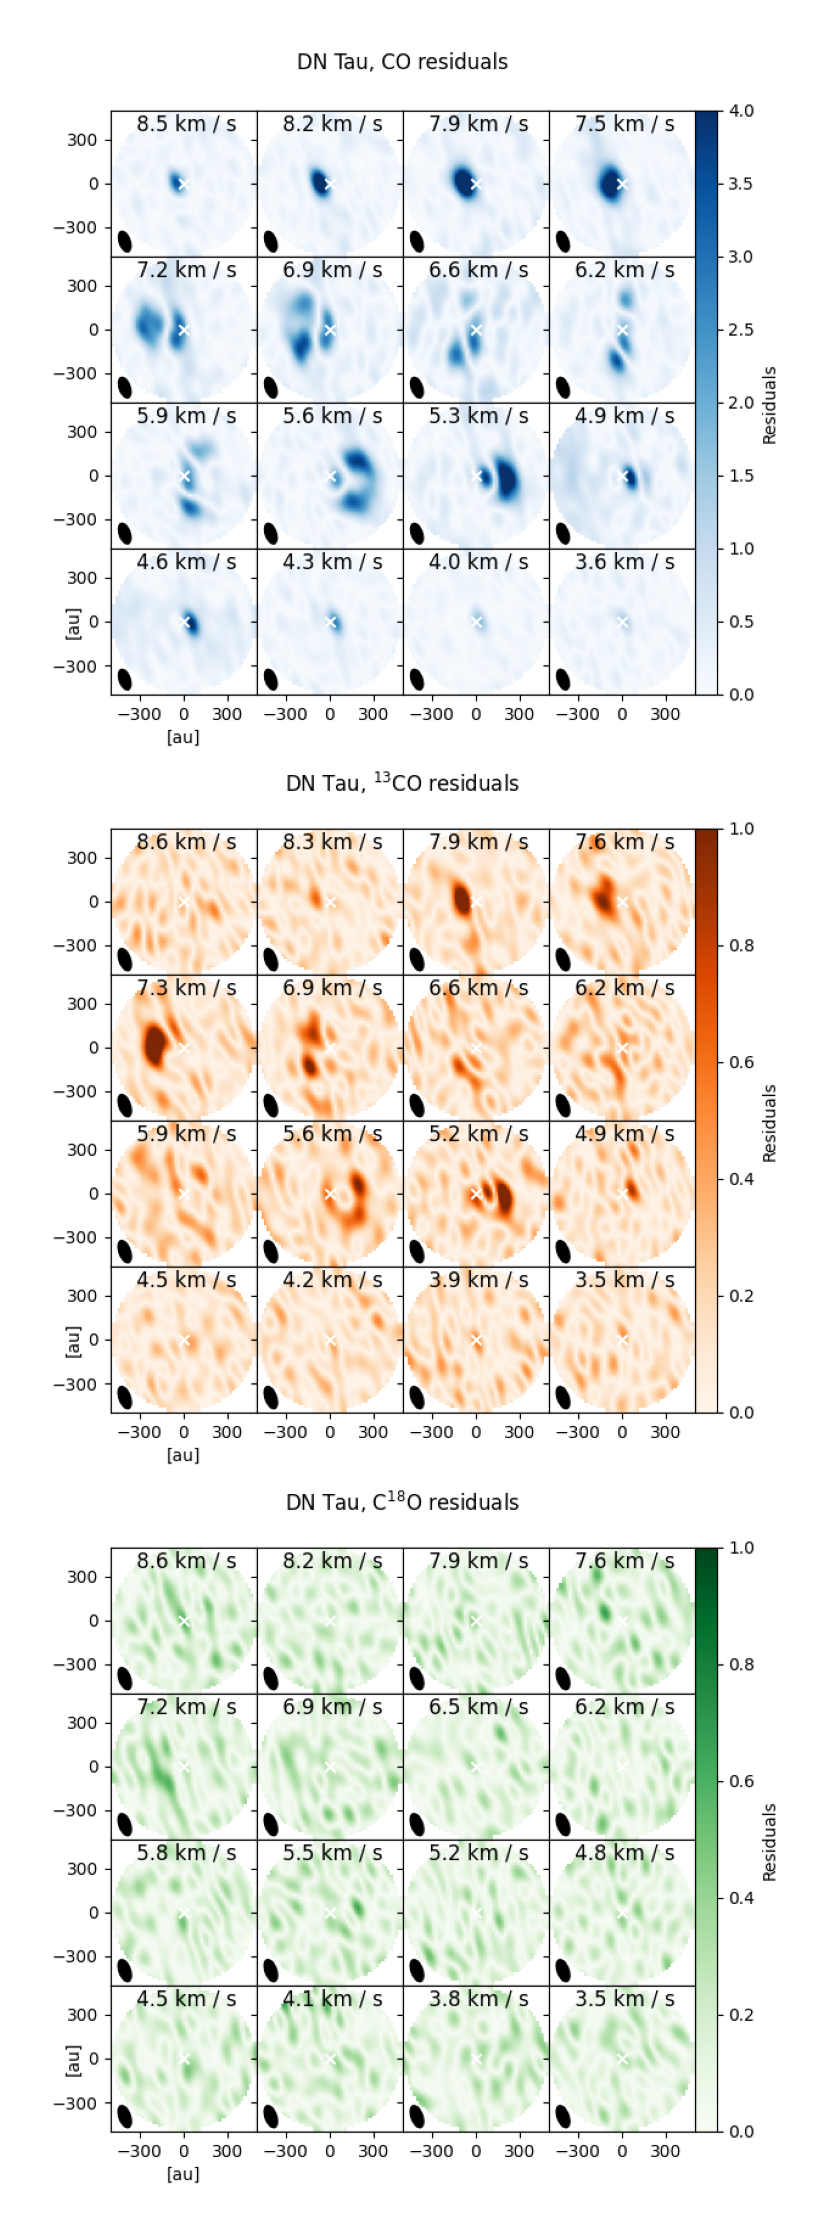

In [32]:
# disk = ["DL Tau"]
# model_path = Path('/Users/franceschi/mysims/diskchef_fitting_greg/Reference/CITau_200_-2.6_60_7_0.55')
molecule = ["CO", "13CO", "C18O"]
root_output = Path(f"/Users/franceschi/Desktop/figs")
ul = 3
upper_limit = [4, 1, 1]
print(f'd: {disk}')
for window, _disk in zip([size], [disk]):
    for i_molecule, _molecule in enumerate(molecule):
        try:
            file = model_path / f'{_molecule}_cut_residuals.fits'
            display(file)
            cube = SpectralCube.read(file)

            center = cube.wcs.celestial.pixel_to_world(cube.shape[1] / 2, cube.shape[2] / 2)
            dist_pc = simbad_data[disks.index(_disk)]["Distance_distance"]
            radius = (
                    window * u.au
                    / (dist_pc * u.pc)
            ).to(
                u.arcsec, equivalencies=u.dimensionless_angles()
            )
            region = CircleSkyRegion(center, radius)
            cube.allow_huge_operations = True
            image_sigma = cube.to(u.K).std()
            mid_channel = cube.closest_spectral_channel((vrange[_disk][0] + vrange[_disk][1]) * 0.5 * u.km / u.s)
            cube = cube[mid_channel - 32: mid_channel + 32]
            cube: SpectralCube = (
                cube.subcube_from_regions([region])
                .to(u.K)
                .with_spectral_unit(u.km / u.s, velocity_convention="radio")
            )

            downsampled: SpectralCube = cube.downsample_axis(4, axis=0).with_spectral_unit(u.km / u.s)
            ny = nx = 4
            # norm = Normalize(0, round(0.9 * downsampled.max().value, 1))
            # norm = Normalize(0, 14)
            norm = Normalize(0, upper_limit[i_molecule])
            cmap = cmaps[molecules.index(_molecule)]
            aspect_ratio = downsampled.shape[2] / float(downsampled.shape[1])
            fig_smallest_dim_inches = 6
            gridratio = ny / float(nx) * aspect_ratio
            if gridratio > 1:
                ysize = fig_smallest_dim_inches * gridratio
                xsize = fig_smallest_dim_inches * gridratio
            else:
                xsize = fig_smallest_dim_inches
                ysize = fig_smallest_dim_inches

            fig: Figure = plt.figure(figsize=(xsize, ysize))
            gs = GridSpec(nrows=ny, ncols=nx, hspace=0.0, wspace=0.0, figure=fig)
            ax = None
            window_half = round(window * 0.6, ndigits=-2)
            for i in range(ny):
                for j in range(nx):
                    ax = fig.add_subplot(
                        gs[i, j],
                        sharex=ax, sharey=ax
                    )
                    dist_pc = simbad_data[disks.index(_disk)]["Distance_distance"]
                    im = ax.imshow(
                        np.abs(downsampled[i * nx + j].value),
                        cmap=cmap,
                        norm=norm,
                        origin="lower",
                        extent=[-window, window, -window, window],
                    )
                    finalize_plot(ax, downsampled, window, dist_pc)
                    ax.text(
                        0.5,
                        0.9,
                        f"{downsampled.spectral_axis[i * nx + j]: .1f}",
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        fontsize=12
                    )
                    if _disk in cloud.keys():
                        velocity = downsampled.spectral_axis[i * nx + j].to_value(u.km / u.s)
                        # print(disk, "has cloud, ", velocity)
                        if cloud[_disk][0] < velocity < cloud[_disk][1] and _molecule in cloud[_disk][2]:
                            # print(velocity, "has cloud")
                            ax.scatter(0.5, 0.5, marker='x', color='red', alpha=0.2, transform=ax.transAxes, s=2000)
                    if i != ny - 1:
                        plt.setp(ax.get_xticklabels(), visible=False)
                    else:
                        ax.set_xticks([-window_half, 0, window_half])
                    if j != 0:
                        plt.setp(ax.get_yticklabels(), visible=False)
                    else:
                        ax.set_yticks([-window_half, 0, window_half])
                    if i == ny - 1 and j == 0:
                        ax.set_xlabel("[au]")
                        ax.set_ylabel("[au]", labelpad=-18)
            else:
                cax = fig.add_axes([0.90, 0.1, 0.03, 0.8])
                cb = fig.colorbar(im, cax=cax, format="%.1f")
                cb.set_label(f"Residuals")
            gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1)
            fig.suptitle(f"{disk}, {chemical_names.from_string(_molecule)} residuals")
            # plt.savefig(f"{molecule}_{disk}_channel_maps_residuals.pdf")
        except (IndexError, OSError) as e:
            print(f"{_disk} {molecule}: error")
            print(traceback.format_exc())
            print(e)
            pass
        path_output = root_output / f"{_disk}_{_molecule}_residuals.png"
        plt.savefig(path_output, bbox_inches="tight")
        plt.close()

path_output = Path(f"/Users/franceschi/Desktop/figs/{_disk}_residuals.png")
residual_paths = []
for _molecule in molecule:
    residual_paths.append(paper_figs_folder / f"{_disk}_{_molecule}_residuals.png")

f, axes = plt.subplots(len(obs_paths), 1, figsize=(12, 7), dpi=400)
for i, _res_path in enumerate(residual_paths):
    _im = mpimg.imread(_res_path)
    axes[i].imshow(_im)

    for _ax in axes:
        _ax.set_axis_off()
    plt.subplots_adjust(hspace=0)

    plt.savefig(path_output, bbox_inches="tight")